## Логистическая регрессия

In [1]:
from math import log, e

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Реализуйте обучение логистической регрессии с $L^1$ и $L^2$ регуляризацией с помощью метода Stochastic Gradient Descent (SGD)

#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """

    def __init__(self, C=1, alpha=0.0005, max_epoch=100, penalty='l2', log_loss=False):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.w = None
        self.loss_history = None
        self.log_loss = log_loss
    
    def fit(self, X, y=None):
        """
        Обучение модели
        X - Тренировочные векторы [n_samples, n_features]
            n_samples - число образцов
            n_features - число признаков
        y - Вектор целевых значений [n_samples]
        """
        # TODO: Узнать зачем сдвигаем X
        X = np.hstack((np.ones((X.shape[0], 1)), X)) # Первый столбец всегда 1

        n_samples, n_features = X.shape

        if self.w is None:
            self.w = np.random.randn(n_features, 1)

        self.loss_history = []

        for epoch in range(self.max_epoch):
            p = np.random.permutation(len(X))
            for idx in p:
                xi = X[[idx]]
                yi = y[idx]
                gradients = xi.T.dot((self._sigmoid(np.dot(xi, self.w)) - yi))
                # gradients = 2 * xi.T.dot(xi.dot(self.w) - yi)
                self.w -= self.alpha * gradients
                if self.log_loss:
                    self.loss_history.append(self._log_loss_all(X, y))
        return self
    
    def partial_fit(self, X, y=None):
        """
        По желанию - метод дообучения модели на новых данных
        """
        return self
        
    def predict(self, X):
        """
        Возвращение метки класса
        """
        y_hat_proba = self.predict_proba(X)
        y_hat = np.argmax(y_hat_proba, axis=1)
        return y_hat

    def predict_proba(self, X):
        """
        Возвращение вероятности каждого из классов
        """
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        predictions = self._sigmoid(X.dot(self.w.flatten().T))
        y_hat_proba = np.vstack([1-predictions, predictions]).T
        return y_hat_proba

    def _log_loss_single(self, x, y):
        prediction = self._sigmoid(np.dot(x, self.w))
        loss = -np.log(prediction) if y == 1.0 else -np.log(1.0 - prediction)
        return loss[0]

    def _log_loss_all(self, X, y):
        predictions = self._sigmoid(np.dot(X, self.w))
        loss = -np.sum(y * np.log(predictions) + (1.0 - y) * np.log(1.0 - predictions))
        return loss / X.shape[0]

    @staticmethod
    def _sigmoid(s):
        return 1.0 / (1.0 + np.exp(-s))

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

In [3]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

model = MySGDClassifier(max_epoch=100, log_loss=True)
model.fit(X, y)

MySGDClassifier(C=1, alpha=0.0005, log_loss=True, max_epoch=100, penalty=None)

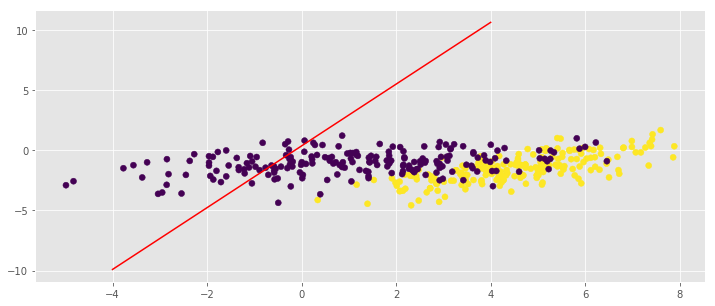

In [4]:
x_naive = np.array([-4, 4])
# Ax + By + C -> y = (-AX -C) / B
y_naive = (-model.w[0] * x_naive - model.w[2] ) / model.w[1]
plt.scatter(X[:,0], X[:,1], c=y)
plt.plot(x_naive, y_naive, c='red', label='descision boundary naive')

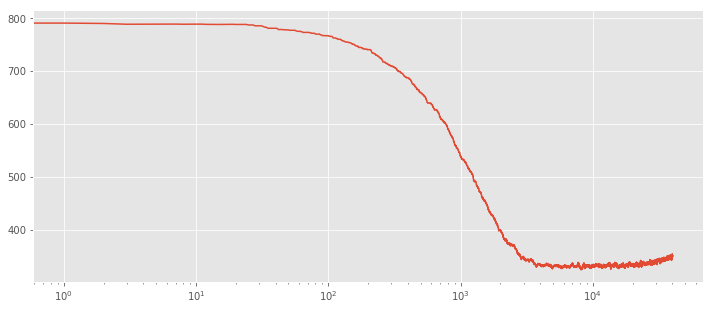

In [5]:
losses = np.array(model.loss_history)

fig, ax= plt.subplots(1, 1)
ax.set_xscale('log')
plt.plot(losses);

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
model = MySGDClassifier(max_epoch=1)

train_scores = []
test_scores = []
num_iters = 1000

for i in range(num_iters):
    model.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, model.predict(X_train)))
    test_scores.append(accuracy_score(y_test, model.predict(X_test)))

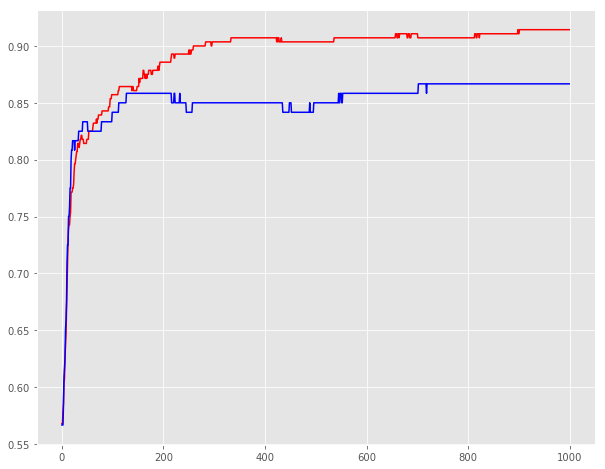

In [8]:
plt.figure(figsize=(10,8))
plt.plot(train_scores, 'r', test_scores, 'b')

## Сравним с реализацией из sklearn

In [9]:
from sklearn import linear_model

In [10]:
model = MySGDClassifier(max_epoch=100)
model.fit(X_train, y_train)

clf = linear_model.SGDClassifier(n_iter=100, loss='log')
clf.fit(X_train, y_train)

print "MySGDClassifier Train f1-score = %.3f" % accuracy_score(y_train, model.predict(X_train))
print "MySGDClassifier Test f1-score = %.3f" % accuracy_score(y_test, model.predict(X_test))

print "SGDClassifier Train f1-score = %.3f" % accuracy_score(y_train, clf.predict(X_train))
print "SGDClassifier Test f1-score = %.3f" % accuracy_score(y_test, clf.predict(X_test))

MySGDClassifier Train f1-score = 0.864
MySGDClassifier Test f1-score = 0.850
SGDClassifier Train f1-score = 0.911
SGDClassifier Test f1-score = 0.867


## Анализ сходимости

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/эпохи (выбрать одно) для разных `alpha`.

In [11]:
## Your Code Here